...

In [28]:
!pip install numpy matplotlib control


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import control.matlab as ctrl

...

In [30]:
w = ctrl.tf([5, 1], [1, 5, 2])
w

TransferFunction(array([5, 1]), array([1, 5, 2]))

...

In [31]:
print(w)
sys_stsp = ctrl.tf2ss(w)
sys_stsp

<TransferFunction>: sys[9]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


   5 s + 1
-------------
s^2 + 5 s + 2



StateSpace(array([[-5., -2.],
       [ 1.,  0.]]), array([[1.],
       [0.]]), array([[5., 1.]]), array([[0.]]))

...

In [32]:
a_matrix = sys_stsp.A
b_matrix = sys_stsp.B
c_matrix = sys_stsp.C
d_matrix = sys_stsp.D
print("A = ", a_matrix, 
      "B = ", b_matrix, 
      "C = ", c_matrix,
      "D = ", d_matrix,
      sep='\n'
      )

A = 
[[-5. -2.]
 [ 1.  0.]]
B = 
[[1.]
 [0.]]
C = 
[[5. 1.]]
D = 
[[0.]]


...

In [42]:
print(f"Poles: {ctrl.pole(w)}")
print(f"Zeros: {ctrl.zero(w)}")

Poles: [-4.56155281+0.j -0.43844719+0.j]
Zeros: [-0.2+0.j]


...

In [41]:
eigvals, _ = np.linalg.eig(a_matrix)
print(f"Eigenvalues (continuous): {eigvals}")

# Controllability
ctrb = np.hstack([b_matrix, a_matrix @ b_matrix])
rank_ctrb = np.linalg.matrix_rank(ctrb)
print("Controllability rank:", rank_ctrb)

# Observability
obsv = np.vstack([c_matrix, c_matrix @ a_matrix])
rank_obsv = np.linalg.matrix_rank(obsv)
print("Observability rank:", rank_obsv)

Eigenvalues (continuous): [-4.56155281 -0.43844719]
Controllability rank: 2
Observability rank: 2


...

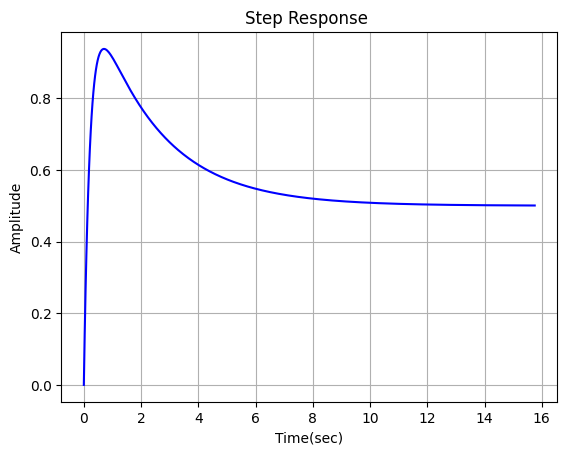

In [36]:
y, x = ctrl.step(w)
plt.plot(x, y, "b")
plt.title('Step Response ')
plt.ylabel('Amplitude')
plt.xlabel('Time(sec)')
plt.grid(True)
plt.show()

...

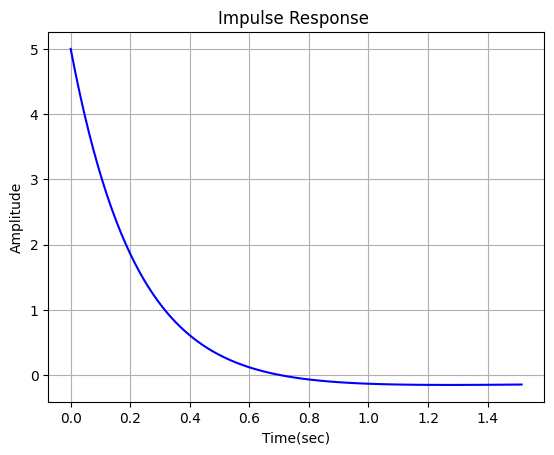

In [38]:
y, x = ctrl.impulse(w)
plt.plot(x, y, "b")
plt.title('Impulse Response ')
plt.ylabel('Amplitude')
plt.xlabel('Time(sec)')
plt.grid(True)
plt.show()

...

C:\Users\vadim\PycharmProjects\LabsSystemTheory\.venv\lib\site-packages\control\freqplot.py:435: FutureWarning: bode_plot() return value of mag, phase, omega is deprecated; use frequency_response()
  warnings.warn(


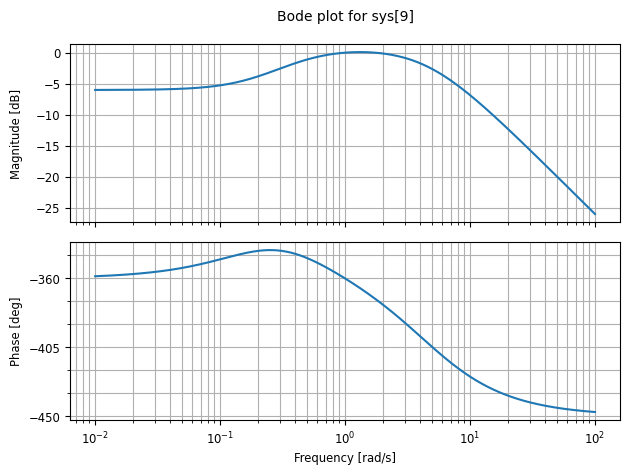

In [43]:
ctrl.bode(w, dB=True)
plt.plot()
plt.show()

...

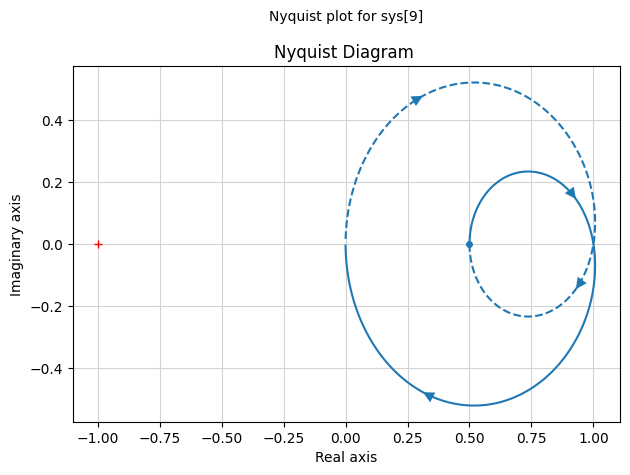

In [40]:
plt.title('Nyquist Diagram ')
plt.ylabel('Imaginary Axis')
plt.xlabel('Real Axis')
ctrl.nyquist(w)
plt.grid(True)
plt.plot()
plt.show()